#  Project Title: Customer Segmentation and Sales Forecasting System for an Online Retailer




#### Dataset Information
- This is a transactional data set which contains all the transactions occurring between 01/12/2024 and 09/12/2025 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.





### Variables Table

| Variable Name | Role     | Type        | Description                                                               | Units    |
|---------------|----------|-------------|---------------------------------------------------------------------------|----------|
| InvoiceNo     | ID       | Categorical | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation |          |
| StockCode     | ID       | Categorical | A 5-digit integral number uniquely assigned to each distinct product      |          |
| Description   | Feature  | Categorical | Product name                                                              |          |
| Quantity      | Feature  | Integer     | The quantities of each product (item) per transaction                     |          |
| InvoiceDate   | Feature  | Date        | The day and time when each transaction was generated                      |          |
| UnitPrice     | Feature  | Continuous  | Product price per unit                                                    | Sterling |
| CustomerID    | Feature  | Categorical | A 5-digit integral number uniquely assigned to each customer              |          |
| Country       | Feature  | Categorical | The name of the country where each customer resides                       |          |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
# remove warnings
import warnings
warnings.filterwarnings("ignore")

## Importing and inspecting the Data 

In [2]:
# Load the dataset
types = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'InvoiceDate': str, 'UnitPrice': float, 'CustomerID': float, 'Country': str}
# Update the file path to the correct location of the CSV file
data = pd.read_csv('../Data/Online_Retail.csv', dtype=types)


In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2024 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2024 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2024 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2024 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2024 8:26,3.39,17850.0,United Kingdom


In [4]:

print(F"The data shape is  {data.shape}")
print(F"-----------------------------------------")
print(F"{data.info()}")


The data shape is  (541909, 8)
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
data.describe(include=['object'])

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2025 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [7]:
#checking for duplicates
print(data.duplicated().sum())

5268


In [8]:
# checking for null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# canceled count
canceled = data[data['InvoiceNo'].str.startswith('C')]
print(F"Canceled count: {canceled.shape[0]}")

Canceled count: 9288


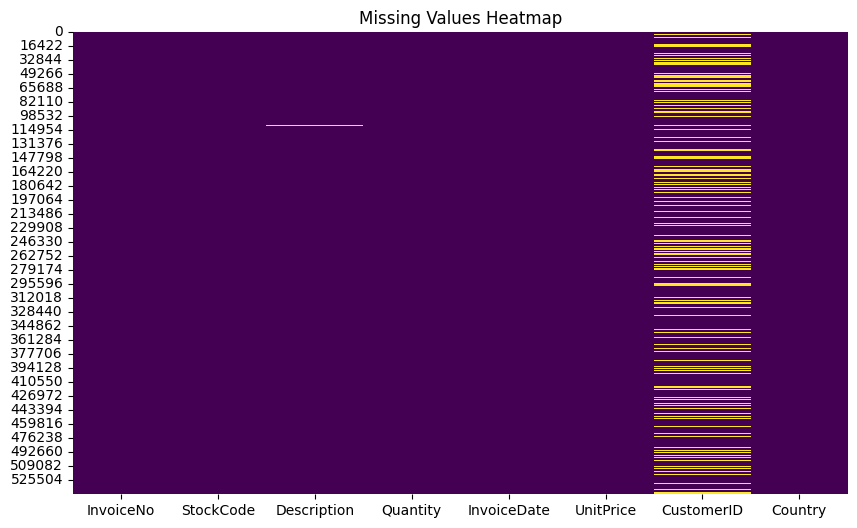

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

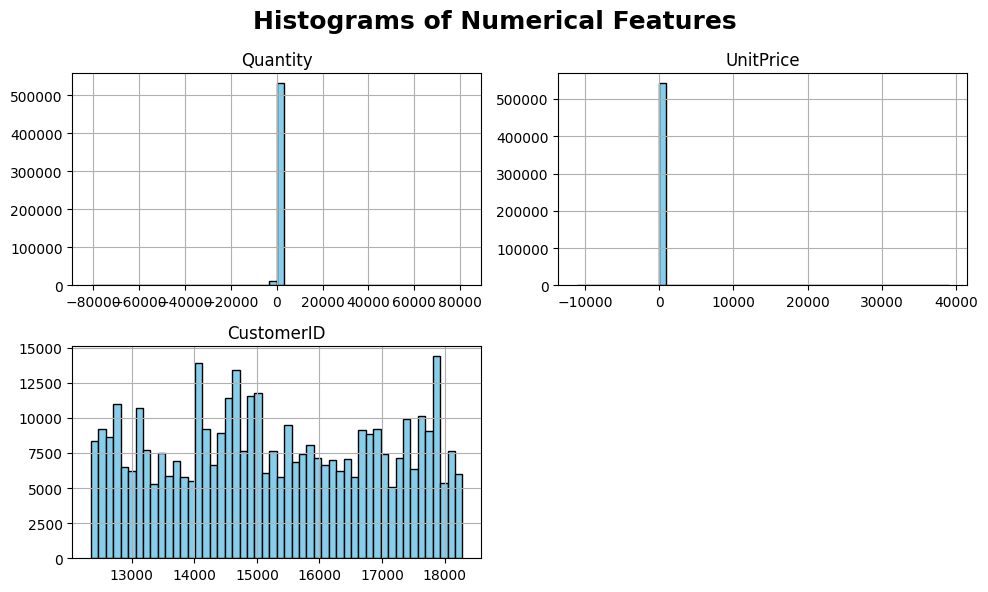

In [11]:
data.hist(
    bins=50, 
    figsize=(10, 6), 
    color='skyblue',  
    edgecolor='black'  
)

plt.suptitle('Histograms of Numerical Features', fontsize=18, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

- Quantity: Shows a highly skewed distribution with most values concentrated near zero, but there are extreme outliers on both the negative and positive sides.
- UnitPrice: Similar to Quantity, it is highly skewed, with most values near zero and a few extreme outliers.
- CustomerID: Shows the distribution of customer IDs, with some IDs appearing more frequently than others.

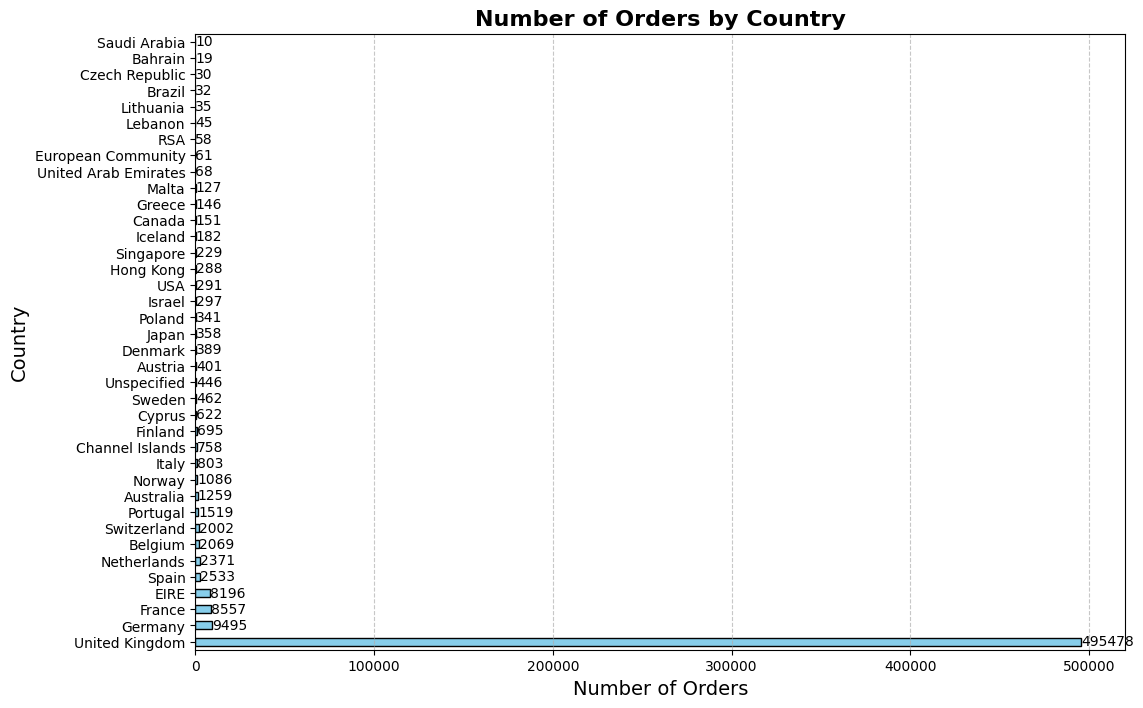

In [12]:
country_counts = data['Country'].value_counts()
ax = country_counts.plot(kind='barh', figsize=(12, 8), color='skyblue', edgecolor='black')

for i, value in enumerate(country_counts):
    plt.text(value + 10, i, str(value), va='center', fontsize=10)  


plt.title('Number of Orders by Country', fontsize=16, fontweight='bold')
plt.xlabel('Number of Orders', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.show()

#### Checking for Outliers

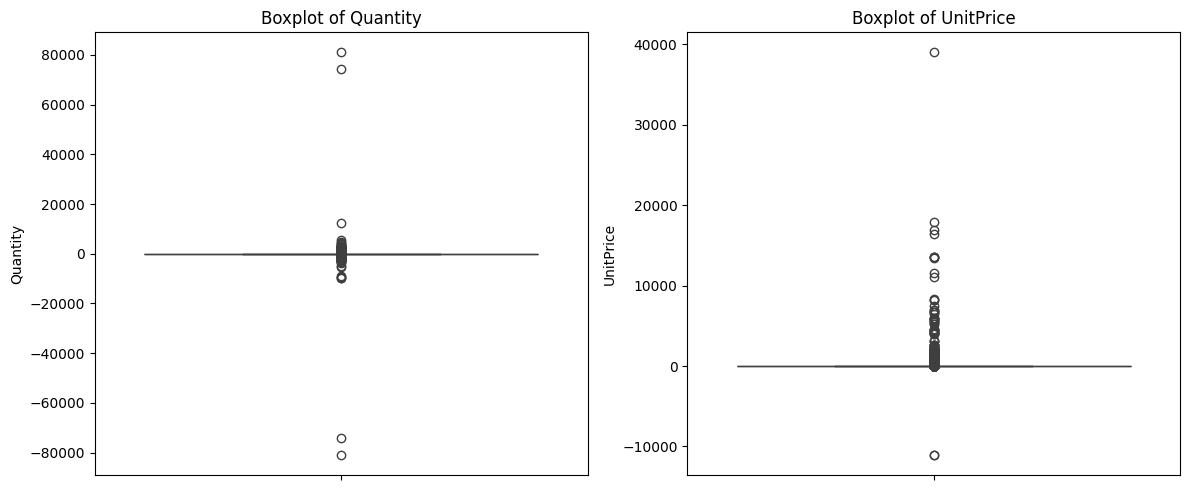

In [13]:
numeric_cols = ['Quantity', 'UnitPrice']

def plot_outliers(data, numeric_cols):
    fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(12, 5))

    
    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()
plot_outliers(data, numeric_cols)


## Data preprocessing

In [14]:
data = data[~data['InvoiceNo'].str.startswith('C')] # Remove cancelled orders

In [15]:
preProcessed_data = data.copy()

- remove duplicates and nulls

In [16]:
preProcessed_data.dropna(inplace=True)
preProcessed_data.drop_duplicates(inplace=True)

### Feature engneering

In [17]:
preProcessed_data['TotalPrice'] = preProcessed_data['Quantity'] * preProcessed_data['UnitPrice']
preProcessed_data['TotalPrice'] = preProcessed_data['TotalPrice'].astype(float)

- splite date

In [18]:
preProcessed_data['Year'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.year
preProcessed_data['Month'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.month
preProcessed_data['Day'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.day
preProcessed_data['Hour'] = pd.to_datetime(preProcessed_data['InvoiceDate']).dt.hour
preProcessed_data['InvoiceDate'] = pd.to_datetime(preProcessed_data['InvoiceDate'])

### Outliers Handling

In [19]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count the number of records to be removed
    initial_count = df.shape[0]
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    removed_count = initial_count - filtered_df.shape[0]
    
    # Print the count of removed records
    print(f"Removed {removed_count} outliers from column '{column}'")
    
    return filtered_df

#### create a version with no outliers

In [20]:
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data, 'Quantity')
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data_with_noOutliers, 'UnitPrice')

Removed 25625 outliers from column 'Quantity'
Removed 33842 outliers from column 'UnitPrice'


Removed 15240 outliers from column 'UnitPrice'


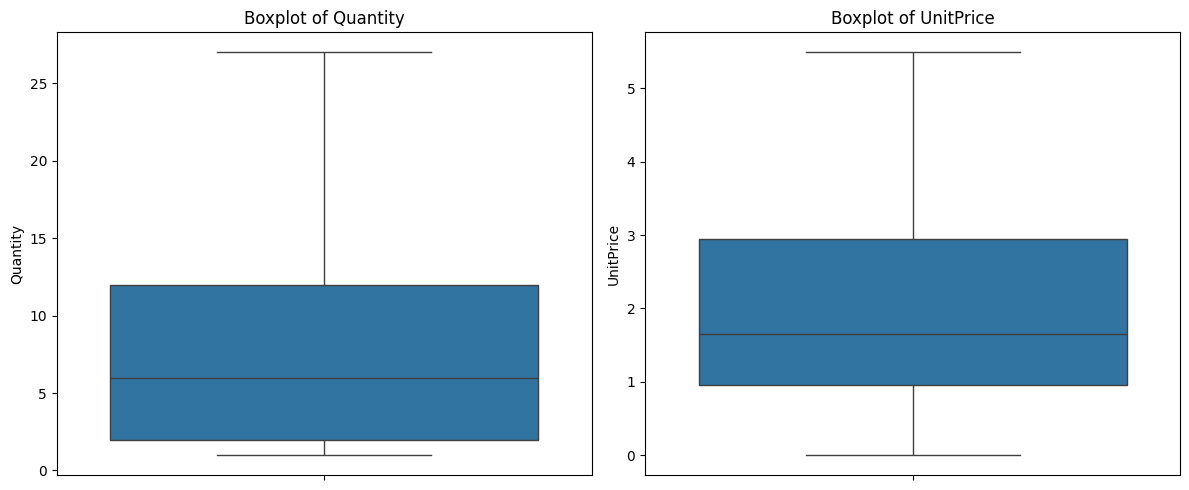

In [21]:
preProcessed_data_with_noOutliers = remove_outliers(preProcessed_data_with_noOutliers, 'UnitPrice')
plot_outliers(preProcessed_data_with_noOutliers, numeric_cols)

## Time series analysis

In [22]:

df = preProcessed_data.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().to_frame()

In [23]:
df = preProcessed_data_with_noOutliers.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
daily_sales_noOutliers = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().to_frame()

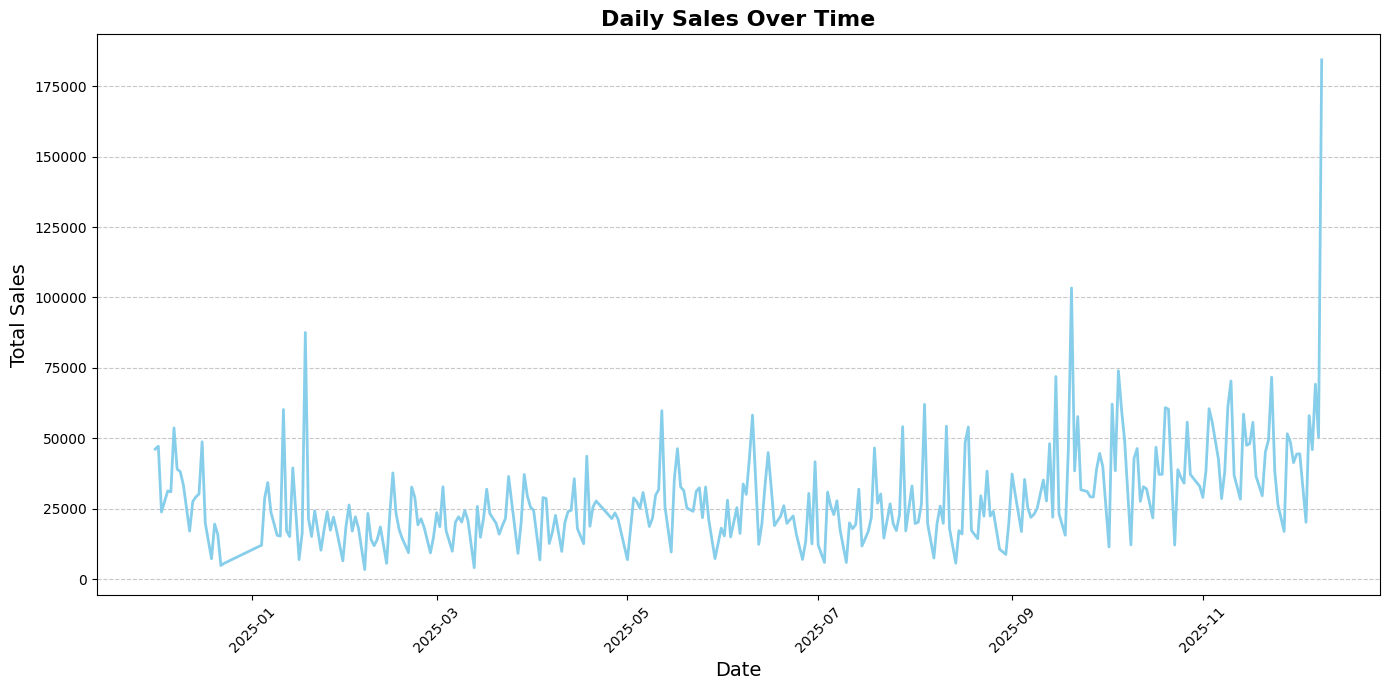

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(daily_sales.index, daily_sales['TotalPrice'], color='skyblue', linewidth=2)
plt.title('Daily Sales Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

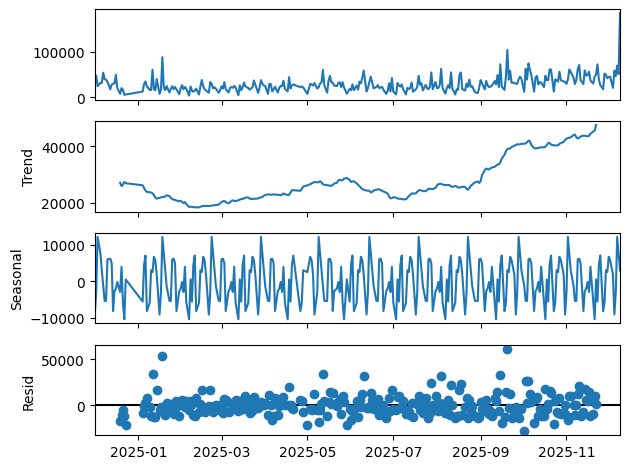

In [25]:


decomposition = seasonal_decompose(daily_sales, model='additive',period=30)
decomposition.plot()
plt.show()

In [26]:


# Perform the ADF test
result = adfuller(daily_sales.dropna())

# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] < 0.05:
    print("The time series is stationary (p-value < 0.05).")
else:
    print("The time series is not stationary (p-value >= 0.05).")

ADF Statistic: -0.37093993146427134
p-value: 0.9148388731385404
The time series is not stationary (p-value >= 0.05).


### Analyize residuals

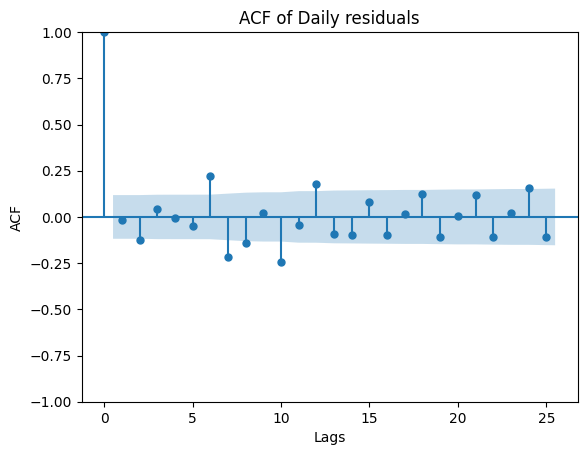

In [27]:


plot_acf(decomposition.resid.dropna())
plt.title('ACF of Daily residuals')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

- The ACF plot suggests that the residuals are mostly random, which is a positive outcome. However, the small significant lags indicate there might still be minor patterns left to address. Further analysis (e.g., stationarity testing or residual modeling) can help refine the results.

In [28]:

result = adfuller(decomposition.resid.dropna())

# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Check if the series is stationary
if result[1] < 0.05:
    print("The resid is stationary (p-value < 0.05).")
else:
    print("The resid is not stationary (p-value >= 0.05).")

ADF Statistic: -8.516951544084012
p-value: 1.1273352456673505e-13
The resid is stationary (p-value < 0.05).


## Time forcasting

### ARIMA MODEL

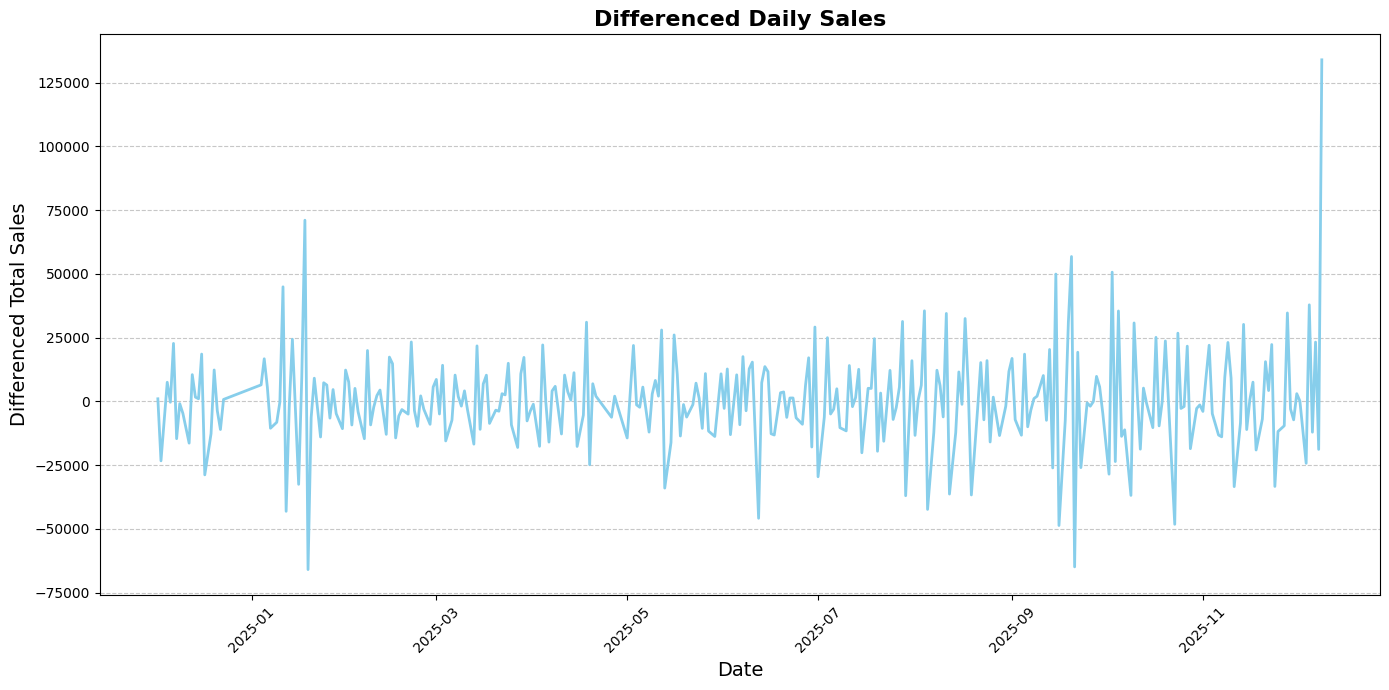

In [29]:
# since daily_sales is not stationary, we will use the differencing method to make it stationary
daily_sales['diff'] = daily_sales['TotalPrice'].diff()
# Drop the first row with NaN value
daily_sales.dropna(inplace=True)
# Plot the differenced series
plt.figure(figsize=(14, 7))
plt.plot(daily_sales.index, daily_sales['diff'], color='skyblue', linewidth=2)
plt.title('Differenced Daily Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Total Sales', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 Since the time series is stationary, we will difference the data to use it in the ARIMA model
- the goal is to find the parameter for the ARIMA model

In [30]:
# Perform the ADF test on the differenced series
daily_sales['diff'] = daily_sales['diff'].dropna()
result = adfuller(daily_sales['diff'].dropna())
# Print the ADF statistic and p-value
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Check if the series is stationary
if result[1] < 0.05:
    print("The differenced series is stationary (p-value < 0.05).")
else:
    print("The differenced series is not stationary (p-value >= 0.05).")


ADF Statistic: -6.3209544470302035
p-value: 3.0671403329914254e-08
The differenced series is stationary (p-value < 0.05).


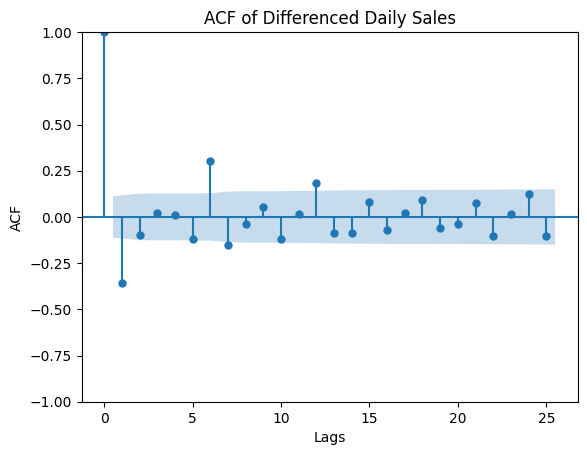

In [31]:

# Plot ACF
plot_acf(daily_sales['diff'])
plt.title('ACF of Differenced Daily Sales')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()


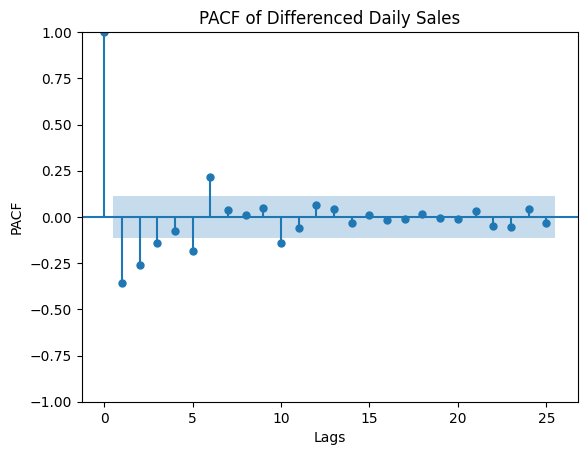

In [32]:
# Plot PACF
plot_pacf(daily_sales['diff'])
plt.title('PACF of Differenced Daily Sales')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

#### Fitting the model

In [33]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(decomposition.resid.dropna(), order=(1, 0, 1))  # d=0 because residual is already differenced
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  275
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2961.450
Date:                Fri, 30 May 2025   AIC                           5930.900
Time:                        17:59:52   BIC                           5945.367
Sample:                             0   HQIC                          5936.706
                                - 275                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -138.9207    727.823     -0.191      0.849   -1565.428    1287.586
ar.L1         -0.4989      0.782     -0.638      0.523      -2.031       1.033
ma.L1          0.5368      0.764      0.703      0.4

#### Trying to predict the resid using ARIMA

In [34]:
# Train/test split
train = daily_sales['TotalPrice'][:90]
test = daily_sales['TotalPrice'][90:]

In [35]:
forecast_resid = fitted_model.forecast(steps=len(test))


In [36]:
# Get matching trend and seasonal components
trend_part = decomposition.trend.dropna()[-len(forecast_resid):]
seasonal_part = decomposition.seasonal[-len(forecast_resid):]

# Add them to residual forecast
final_forecast = forecast_resid + trend_part.values + seasonal_part.values


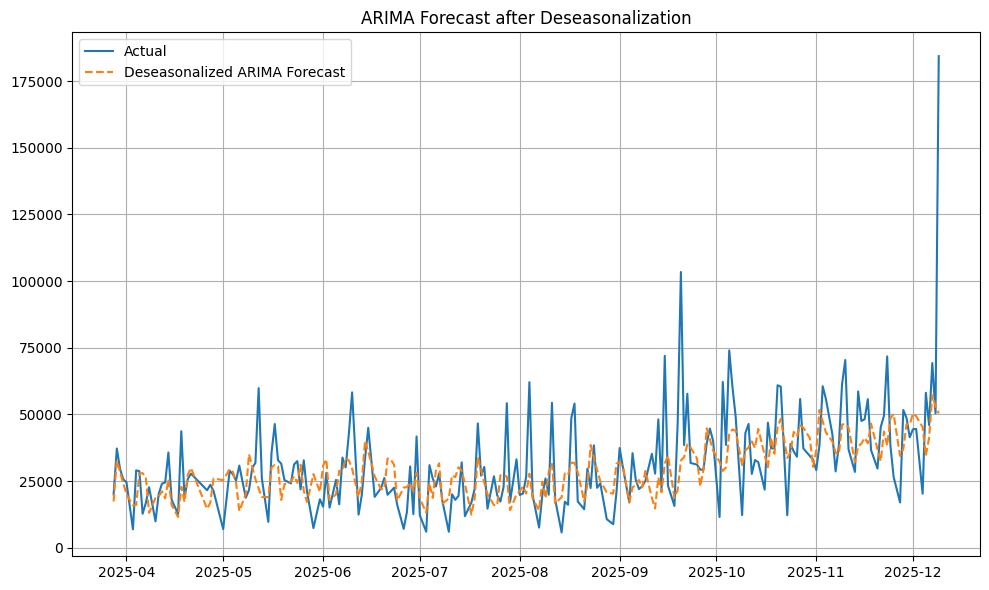

In [37]:
plt.figure(figsize=(10,6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='Deseasonalized ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast after Deseasonalization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Captures overall direction:

The forecasted line shows rising trends when actual sales increase — suggesting that the trend and seasonality components were re-added correctly.


What Still Needs Attention
Forecast underestimates extreme spikes:

The model smooths out the data and can’t fully capture sharp peaks (e.g., sudden spikes above 80k–100k).

This is expected from ARIMA, which is best at modeling consistent, linear-ish behavior — not outliers or shock events.

### Try the same approach without outliers and apply:
- smoothing 
- seasonal order (SARIMA)

In [38]:
df = preProcessed_data_with_noOutliers.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date


data_with_noOutliers_smoothed = df.groupby(['InvoiceDate']).agg({'TotalPrice': 'sum'})


In [39]:
data_with_noOutliers_smoothed['TotalPrice'] = data_with_noOutliers_smoothed['TotalPrice'].rolling(window=7).mean()
data_with_noOutliers_smoothed.dropna(inplace=True)


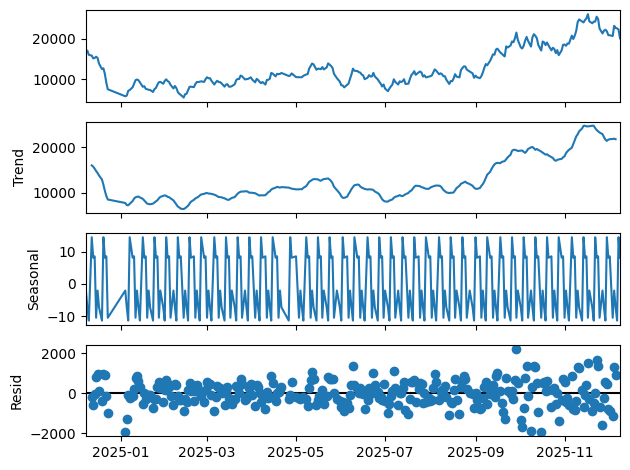

In [40]:
# decompose the smoothed series
decomposition_smooth = seasonal_decompose(data_with_noOutliers_smoothed, model='additive', period=7)
decomposition_smooth.plot()
plt.show()

In [41]:
# # get the optimal ARIMA model using auto_arima
from pmdarima import auto_arima
auto_model = auto_arima(data_with_noOutliers_smoothed['TotalPrice'], seasonal=True, m=7, stepwise=True)
print(auto_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  299
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -2348.977
Date:                                Fri, 30 May 2025   AIC                           4711.954
Time:                                        18:00:05   BIC                           4737.834
Sample:                                             0   HQIC                          4722.314
                                                - 299                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     67.3969     16.652      4.047      0.000      34.759     100.035
ma.

In [42]:
# predict the residuals using an ARIMA model with optimal parameters
model = ARIMA(decomposition_smooth.resid.dropna(), order=(0, 1, 1), seasonal_order=(2, 0, [1,2], 7))
fitted_model = model.fit()
print(fitted_model.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                resid   No. Observations:                  293
Model:             ARIMA(0, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -2200.541
Date:                              Fri, 30 May 2025   AIC                           4413.081
Time:                                      18:00:06   BIC                           4435.142
Sample:                                           0   HQIC                          4421.918
                                              - 293                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9970      0.076    -13.044      0.000      -1.147      -0.847
ar.S.L7        0.54

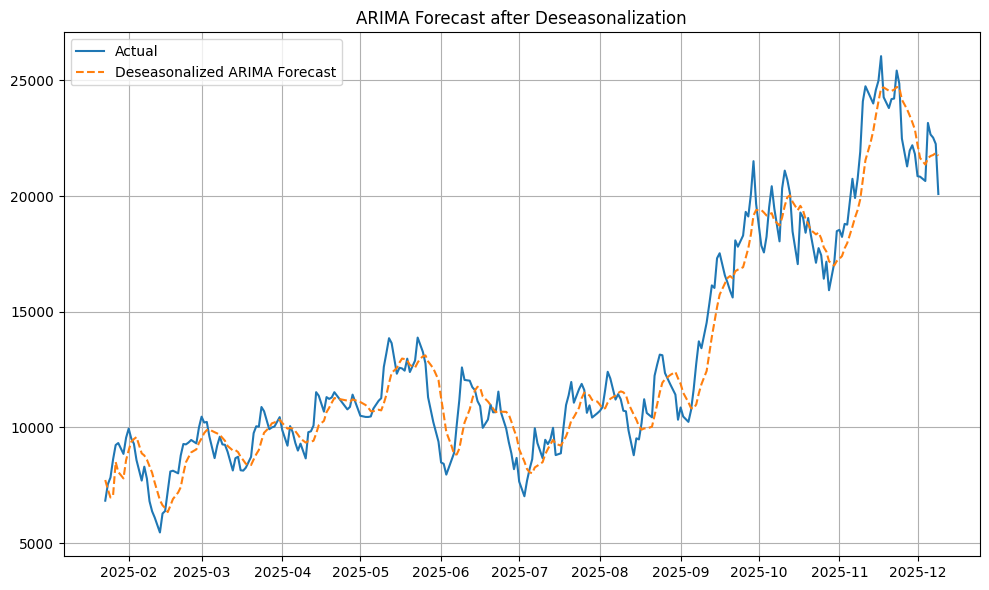

In [43]:
train = data_with_noOutliers_smoothed['TotalPrice'][:30]
test = data_with_noOutliers_smoothed['TotalPrice'][30:]
forecast_resid = fitted_model.forecast(steps=len(test))

trend_part = decomposition_smooth.trend.dropna()[-len(forecast_resid):]
seasonal_part = decomposition_smooth.seasonal[-len(forecast_resid):]

final_forecast = forecast_resid + trend_part.values + seasonal_part.values
plt.figure(figsize=(10,6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='Deseasonalized ARIMA Forecast', linestyle='--')
plt.title('ARIMA Forecast after Deseasonalization')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:


r2 = r2_score(test, final_forecast)
print(f"R-squared: {r2}")

R-squared: 0.948257857909399


An R-squared value of 0.948 indicates that the model explains 94.8% of the variance in the actual sales data. This is a strong result, suggesting that the ARIMA model performs well in capturing the overall trend and seasonality of the data. However, it may still struggle with extreme spikes or outliers, as seen in the visualization.

#### Forecast for the next 180 days


In [45]:
future_steps = 180
future_forecast_resid = fitted_model.forecast(steps=future_steps)


future_trend = decomposition_smooth.trend.dropna()[-future_steps:]
future_seasonal = decomposition_smooth.seasonal[-future_steps:]

future_final_forecast = future_forecast_resid + future_trend.values + future_seasonal.values

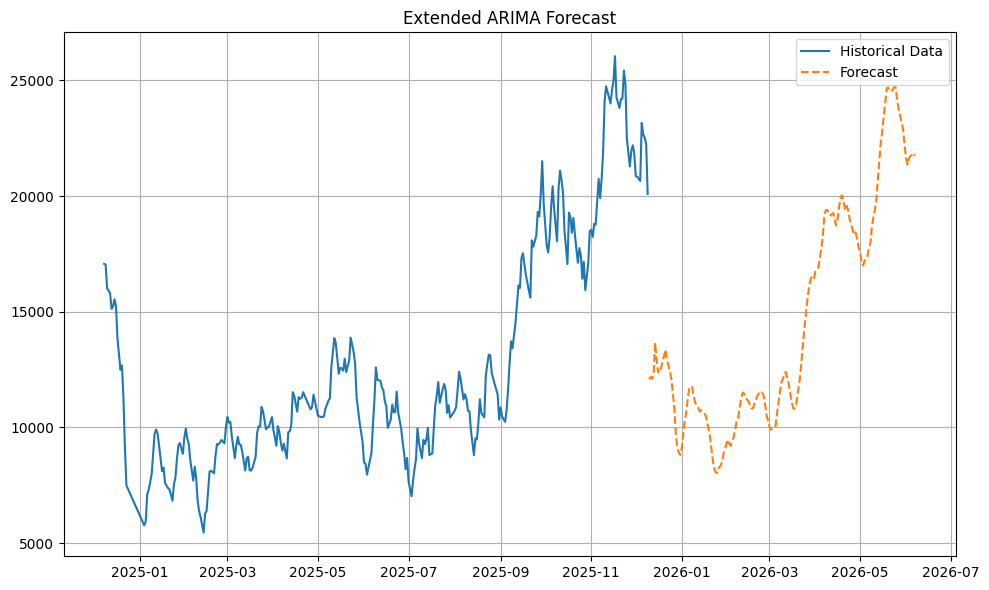

In [46]:
future_dates = pd.date_range(
    start=data_with_noOutliers_smoothed.index[-1], 
    periods=future_steps + 1,                     
    freq='D'                                      
)[1:]                                             


plt.figure(figsize=(10, 6))
plt.plot(data_with_noOutliers_smoothed.index, data_with_noOutliers_smoothed['TotalPrice'], label='Historical Data')
plt.plot(future_dates, future_final_forecast, label='Forecast', linestyle='--')
plt.title('Extended ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The forecast captures the general trend and seasonality of the historical data.
There is a noticeable upward trend in the forecasted period, reflecting the model's ability to project ongoing growth.

In [47]:
# import pickle
# # Save the fitted model to a file
# with open('../Model/arima_model.pkl', 'wb') as f:
#     pickle.dump(fitted_model, f)


In [48]:
future_steps = 30


future_forecast_resid = fitted_model.forecast(steps=future_steps)


future_trend = decomposition_smooth.trend.dropna()[-future_steps:]
future_seasonal = decomposition_smooth.seasonal[-future_steps:]

future_final_forecast = future_forecast_resid + future_trend.values + future_seasonal.values
future_final_forecast

293    18851.715124
294    18896.574387
295    18937.447987
296    19342.173683
297    21403.260422
298    21531.061922
299    21817.737446
300    22715.172621
301    23429.072401
302    24171.574872
303    24760.472518
304    24992.596956
305    24373.947985
306    24355.420017
307    24485.905762
308    24743.921690
309    24894.696454
310    24395.915912
311    23682.347080
312    23389.161850
313    23259.214393
314    22848.581947
315    22252.470512
316    21725.361091
317    21454.426639
318    21504.200509
319    21743.551110
320    21876.117536
321    21887.681568
322    21757.233518
Name: predicted_mean, dtype: float64